# SMorph: Single Cell Analysis

---
## Setup
Please execute the cell(s) below to initialize the notebook environment.

In [38]:
# @title Install dependencies
#!pip install poetry

In [39]:
# @title Install SMorph Python module
#!pip install https://github.com/swanandlab/SMorph/releases/download/0.1.0/SMorph-0.1.0.tar.gz

In [5]:
import warnings
warnings.filterwarnings('ignore')  # Suppress annoying warnings

#import smorph as sm
import skimage
import matplotlib.pyplot as plt
import ipywidgets as widgets

In [6]:
def plot(img):
  """Helper one line function for plotting"""
  plt.imshow(img, cmap='gray')

  
  plt.axis('off')
  plt.show()

---
## Step 1: Load image and select preprocessing parameters

Set `IMG_PATH` as string to the path of a cell image to be analyzed

---
## Step 2: Start single cell analysis

Sholl analysis parameters:
- Set `SHOLL_STEP_SIZE` as int to difference (in pixels) between concentric Sholl circles
- Set `POLYNOMIAL_DEGREE` as int to degree of polynomial for fitting regression model on Sholl values

In [7]:
SHOLL_STEP_SIZE = 3  #@param
POLYNOMIAL_DEGREE = 5  #@param

In [8]:
import tifffile as tf
from smorph.core.api import Cell
import pandas as pd
import pandas as pd

#inImg = tf.TiffFile('../Bahareh/1796_labeledMG.tif').pages[0].asarray()

In [9]:
#inImg.shape

In [10]:
inDF = pd.read_csv('../Bahareh/data/fig7_mg_raw.csv')
inDF.loc[:,'CellID'] = inDF.ImageID_CellID.str.split('_',expand=True)[1].astype(int)
inDF


,Unnamed: 0,spatial_X,spatial_Y,Area,Area (µm^2),ImageID,ImageType,Parent,Distance to nearest Plaque (µm),ImageID_CellID,numCellCentroids,ImageIDOLD,CellID
0,1790,13574.364621,11980.732852,277,61.1722,Ctl-3,Ctl,Grey Matter,348.1208,1796_1791,1.0,1796,1791
1,1794,13491.046358,11876.990066,302,53.9108,Ctl-3,Ctl,Grey Matter,308.6889,1796_1795,1.0,1796,1795
2,1795,14676.054795,11854.070776,438,82.4693,Ctl-3,Ctl,Grey Matter,432.9919,1796_1796,1.0,1796,1796
3,1796,13395.029412,11854.349790,952,185.9480,Ctl-3,Ctl,Grey Matter,303.5456,1796_1797,1.0,1796,1797
4,1797,15292.282609,11814.693237,828,171.9872,Ctl-3,Ctl,Grey Matter,353.9196,1796_1798,1.0,1796,1798
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48141,143982,39.883575,15885.947766,1589,269.7662,Ctl-2,Ctl,White Matter,NaN,3628_19351,1.0,3628,19351
48142,143983,331.334215,15758.689594,1134,204.2505,Ctl-2,Ctl,White Matter,NaN,3628_19352,1.0,3628,19352
48143,143986,140.715271,15603.225616,1015,172.7699,Ctl-2,Ctl,White Matter,NaN,3628_19355,1.0,3628,19355
48144,143987,129.878453,15529.645304,1810,347.2530,Ctl-2,Ctl,White Matter,NaN,3628_19356,1.0,3628,19356


In [11]:
def getCrop(inM, keepID):
    # Find the coordinates of all non-zero pixels with the specified keepID
    non_zero_coords = np.argwhere(inM == keepID)
    # Extract the minimum and maximum x and y coordinates
    x_min, y_min = np.min(non_zero_coords, axis=0)
    x_max, y_max = np.max(non_zero_coords, axis=0)
    # Calculate width (w) and height (h) based on the min and max coordinates
    # pad by 50
    pad = 50
    #w = x_max - x_min + pad
    #h = y_max - y_min + pad
    
    return (inM[max(0,x_min-pad):min(x_max+pad, inM.shape[0]), max(y_min-pad,0):min(y_max+pad, inM.shape[1])]==keepID).astype(np.uint8)

import dask
from dask.diagnostics import ProgressBar

# Helper function for processing each row
from skimage.morphology import skeletonize,  binary_dilation
import numpy as np
import matplotlib.pyplot as plt

def process_row(inIm, row):
    flag = 1
    cell_image = binary_dilation(getCrop(inIm, keepID =row.CellID))

    try:
        cell = Cell(cell_image, image_type='DAB', crop_tech='manual',
                    sholl_step_size=SHOLL_STEP_SIZE,
                    polynomial_degree=POLYNOMIAL_DEGREE)
    except:
        print(row.name, row, "ERRR")
        flag = 0
    if flag:
        return pd.Series(cell.features)
    else:
        return pd.Series({})


In [12]:
def getInputs(iDF, imID):
    oDF = iDF[iDF.ImageIDOLD==imID]
    print(f"Reading image file: ../Bahareh/GMask/{imID}_labeledMG.tif" )
    inImg = tf.TiffFile(f'../Bahareh/GMask/{imID}_labeledMG.tif').pages[0].asarray()
    return oDF, inImg


In [13]:
import cv2
def get_soma_radius(cell_image):
    """Calculate pixel position to be attribute as soma."""
    #https://stackoverflow.com/questions/4279478/largest-circle-inside-a-non-convex-polygon
    # soma_blobs = _get_blobs(cell_image, image_type)

    # if len(soma_blobs) == 0:
    #     raise RuntimeError('No soma detected for the cell!')
    # if len(soma_blobs) == 1:
    #     soma = soma_blobs[0][:2]
    # if len(soma_blobs) > 1:
    #     #soma = _centre_of_mass(soma_blobs, cell_image, image_type)
    #     soma = soma_blobs[np.argmax(soma_blobs[:, 2]),:2]
    
    dist_map = cv2.distanceTransform(cell_image.astype(np.uint8), cv2.DIST_L2, cv2.DIST_MASK_PRECISE)
    _,radius, _, center = cv2.minMaxLoc(dist_map)
    return radius

def process_row2(inIm, row):
    flag = 1
    cell_image = binary_dilation(getCrop(inIm, keepID =row.CellID))
    try:
        sRad = get_soma_radius(cell_image)
    except:
        sRad = 0
        
    cell_features = {'Area':cell_image.sum(),'Soma Radius':sRad}
    if flag:
        return pd.Series(cell_features),cell_image
    else:
        return pd.Series({})

In [14]:
import os
from tqdm.notebook import tqdm

for imID in tqdm(inDF.ImageIDOLD.unique(), total=8):
    #if os.path.exists(f'../Bahareh/Mout/{imID}_MG_SkelFeat_AreaOnly.csv'):
    #    print(f'../Bahareh/Mout/{imID}_MG_SkelFeat.csv exists. Skipping...')
    #    continue
    oDF, inImg = getInputs(inDF, imID)
    print(oDF.shape)
    results = []
    iCnt = 0
    for ix, row in tqdm(oDF.iterrows(), total=oDF.shape[0]):
        _, cIm = process_row2(inImg, row)
        if iCnt==4:
            break
        iCnt += 1
    break
        #results.append(process_row2(inImg, row))
    #oDF = pd.concat([oDF, pd.DataFrame(results, index=oDF.index)], axis=1)
    #oDF.to_csv(f'../Bahareh/Mout/{imID}_MG_SkelFeat_AreaOnly.csv', index=False)
#oDF = pd.concat([oDF] + results, axis=1)

# The ProgressBar will show the progress of the computations
#with ProgressBar():
#    oDF = oDF.compute()

# Display the updated DataFrame
print(oDF.head())

  0%|          | 0/8 [00:00<?, ?it/s]

Reading image file: ../Bahareh/GMask/1796_labeledMG.tif
(5071, 13)


  0%|          | 0/5071 [00:00<?, ?it/s]

   Unnamed: 0     spatial_X     spatial_Y  Area  Area (µm^2) ImageID  \
0        1790  13574.364621  11980.732852   277      61.1722   Ctl-3   
1        1794  13491.046358  11876.990066   302      53.9108   Ctl-3   
2        1795  14676.054795  11854.070776   438      82.4693   Ctl-3   
3        1796  13395.029412  11854.349790   952     185.9480   Ctl-3   
4        1797  15292.282609  11814.693237   828     171.9872   Ctl-3   

  ImageType       Parent  Distance to nearest Plaque (µm) ImageID_CellID  \
0       Ctl  Grey Matter                         348.1208      1796_1791   
1       Ctl  Grey Matter                         308.6889      1796_1795   
2       Ctl  Grey Matter                         432.9919      1796_1796   
3       Ctl  Grey Matter                         303.5456      1796_1797   
4       Ctl  Grey Matter                         353.9196      1796_1798   

   numCellCentroids  ImageIDOLD  CellID  
0               1.0        1796    1791  
1               1.0       

In [14]:
morphDF = pd.read_csv('../Bahareh/morph_exp/morphFeat.csv')
morphDF

,Unnamed: 0,spatial_X,spatial_Y,Area,Area (µm^2),ImageID,ImageType,Parent,Distance to nearest Plaque (µm),ImageID_CellID,...,ramification_index,skewness,coefficient_of_determination,sholl_regression_coefficient,regression_intercept,Cell Area,Soma Radius,Convex Hull Area,Solidity,leiden
0,1790,13574.364621,11980.732852,277,61.1722,Ctl-3,Ctl,Grey Matter,348.1208,1796_1791,...,inf,-3.47,0.98,1.15,-1.35,495.0,6.000000,732.0,0.676230,3
1,1794,13491.046358,11876.990066,302,53.9108,Ctl-3,Ctl,Grey Matter,308.6889,1796_1795,...,NaN,NaN,NaN,NaN,NaN,412.0,9.219544,435.0,0.947126,3
2,1795,14676.054795,11854.070776,438,82.4693,Ctl-3,Ctl,Grey Matter,432.9919,1796_1796,...,1.04,0.52,0.97,0.13,-2.03,639.0,7.211102,856.0,0.746495,2
3,1796,13395.029412,11854.349790,952,185.9480,Ctl-3,Ctl,Grey Matter,303.5456,1796_1797,...,1.06,0.58,0.95,1.68,0.86,1453.0,8.000000,2475.0,0.587071,3
4,1797,15292.282609,11814.693237,828,171.9872,Ctl-3,Ctl,Grey Matter,353.9196,1796_1798,...,1.75,-0.10,0.83,1.03,-0.97,1362.0,7.810250,2522.0,0.540048,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48141,143982,39.883575,15885.947766,1589,269.7662,Ctl-2,Ctl,White Matter,NaN,3628_19351,...,NaN,NaN,NaN,NaN,NaN,0.0,0.000000,0.0,NaN,6
48142,143983,331.334215,15758.689594,1134,204.2505,Ctl-2,Ctl,White Matter,NaN,3628_19352,...,0.87,0.57,0.94,0.07,-2.26,1560.0,12.000000,2340.0,0.666667,2
48143,143986,140.715271,15603.225616,1015,172.7699,Ctl-2,Ctl,White Matter,NaN,3628_19355,...,1.58,0.36,0.91,0.11,-2.05,1295.0,13.152946,1703.0,0.760423,1
48144,143987,129.878453,15529.645304,1810,347.2530,Ctl-2,Ctl,White Matter,NaN,3628_19356,...,1.30,-0.02,0.96,0.06,-2.11,2689.0,11.401754,5581.0,0.481813,6


In [15]:
from skimage.morphology import convex_hull_image
from skan.csr import Skeleton, summarize
from skan import csr
from skan.csr import skeleton_to_csgraph
from skimage import morphology

def process_row3(inIm, row):
    flag = 1
    cell_image = binary_dilation(getCrop(inIm, keepID =row.CellID))
    #plt.imshow(cell_image)
    #plt.imshow(morphology.skeletonize(cell_image, method='lee'))
    #print(summarize(Skeleton(morphology.skeletonize(cell_image, method='lee'))))
    cell = Cell(cell_image, image_type='DAB', crop_tech='manual',
                sholl_step_size=1,
                polynomial_degree=1)
    #print(row.name, row, "ERRR")
    flag = 1
    if flag:
        return pd.Series(cell.features), cell_image, cell
    else:
        return pd.Series({})

In [16]:
morphDF.no_of_forks

0        0.0
1        NaN
2        1.0
3        2.0
4        4.0
        ... 
48141    NaN
48142    3.0
48143    1.0
48144    9.0
48145    NaN
Name: no_of_forks, Length: 48146, dtype: float64

In [17]:
import cv2
from skimage.morphology import convex_hull_image

def get_soma_radius(cell_image):
    """Calculate pixel position to be attribute as soma."""
    #https://stackoverflow.com/questions/4279478/largest-circle-inside-a-non-convex-polygon
    # soma_blobs = _get_blobs(cell_image, image_type)

    # if len(soma_blobs) == 0:
    #     raise RuntimeError('No soma detected for the cell!')
    # if len(soma_blobs) == 1:
    #     soma = soma_blobs[0][:2]
    # if len(soma_blobs) > 1:
    #     #soma = _centre_of_mass(soma_blobs, cell_image, image_type)
    #     soma = soma_blobs[np.argmax(soma_blobs[:, 2]),:2]
    
    dist_map = cv2.distanceTransform(cell_image.astype(np.uint8), cv2.DIST_L2, cv2.DIST_MASK_PRECISE)
    _,radius, _, center = cv2.minMaxLoc(dist_map)
    return radius



def process_rowF(inIm, row):
    cell_image = binary_dilation(getCrop(inIm, keepID =row.CellID))

    flag = 1
    try:
        sRad = get_soma_radius(cell_image)
    except:
        sRad = 0
    cIxIm = convex_hull_image(cell_image)
    cell_features = {'Cell Area':cell_image.sum(),'Soma Radius':sRad, 'Convex Hull Area':cIxIm.sum(), 'Solidity':cell_image.sum()/cIxIm.sum()}
    if flag:
        return pd.Series(cell_features)
    else:
        print("ERR")
        return pd.Series({})

In [18]:
import os
from tqdm.notebook import tqdm

for imID in tqdm(inDF.ImageIDOLD.unique(), total=8):

    #if os.path.exists(f'../Bahareh/Mout/{imID}_MG_SkelFeat_AreaOnly.csv'):
    #    print(f'../Bahareh/Mout/{imID}_MG_SkelFeat.csv exists. Skipping...')
    #    continue
    oDF, inImg = getInputs(inDF, imID)
    subDF = morphDF[(morphDF.ImageIDOLD == imID) & (morphDF.no_of_forks.isna())]
    oDF = oDF[oDF.ImageID_CellID.isin(subDF.ImageID_CellID.values)]
    print(imID, oDF.shape)
    resultsA = []

    iCnt = 0
    for ix, row in tqdm(oDF.iterrows(), total=oDF.shape[0]):
        resultsA.append(process_rowF(inImg, row))


    oDF2 = pd.concat([oDF, pd.DataFrame(resultsA, index=oDF.index)], axis=1)
    oDF2.to_csv(f'../Bahareh/Mout/{imID}_MG_SkelFeat_Missing_AreaF.csv', index=False)
    

  0%|          | 0/8 [00:00<?, ?it/s]

Reading image file: ../Bahareh/GMask/1796_labeledMG.tif
1796 (92, 13)


  0%|          | 0/92 [00:00<?, ?it/s]

Reading image file: ../Bahareh/GMask/3196_labeledMG.tif
3196 (61, 13)


  0%|          | 0/61 [00:00<?, ?it/s]

Reading image file: ../Bahareh/GMask/2997_labeledMG.tif
2997 (76, 13)


  0%|          | 0/76 [00:00<?, ?it/s]

Reading image file: ../Bahareh/GMask/1873_labeledMG.tif
1873 (126, 13)


  0%|          | 0/126 [00:00<?, ?it/s]

Reading image file: ../Bahareh/GMask/3026_labeledMG.tif
3026 (130, 13)


  0%|          | 0/130 [00:00<?, ?it/s]

Reading image file: ../Bahareh/GMask/3155_labeledMG.tif
3155 (243, 13)


  0%|          | 0/243 [00:00<?, ?it/s]

Reading image file: ../Bahareh/GMask/3280_labeledMG.tif
3280 (163, 13)


  0%|          | 0/163 [00:00<?, ?it/s]

Reading image file: ../Bahareh/GMask/3628_labeledMG.tif
3628 (92, 13)


  0%|          | 0/92 [00:00<?, ?it/s]

In [47]:
import os
from tqdm.notebook import tqdm

for imID in tqdm(inDF.ImageIDOLD.unique(), total=8):
    if imID==1796:
        print("Skipping", imID)
        continue
    #if os.path.exists(f'../Bahareh/Mout/{imID}_MG_SkelFeat_AreaOnly.csv'):
    #    print(f'../Bahareh/Mout/{imID}_MG_SkelFeat.csv exists. Skipping...')
    #    continue
    oDF, inImg = getInputs(inDF, imID)
    subDF = morphDF[(morphDF.ImageIDOLD == imID) & (morphDF.no_of_forks.isna())]
    oDF = oDF[oDF.ImageID_CellID.isin(subDF.ImageID_CellID.values)]
    print(imID, oDF.shape)
    results = []
    resultsA = []

    iCnt = 0
    for ix, row in tqdm(oDF.iterrows(), total=oDF.shape[0]):
        _, cIm = process_row2(inImg, row)
        results.append(process_row3(inImg, row)[0])
        resultsA.append(process_row2(inImg, row)[0])

    oDF1 = pd.concat([oDF, pd.DataFrame(results, index=oDF.index)], axis=1)
    oDF1.to_csv(f'../Bahareh/Mout/{imID}_MG_SkelFeat_Missing.csv', index=False)
    oDF2 = pd.concat([oDF, pd.DataFrame(resultsA, index=oDF.index)], axis=1)
    oDF2.to_csv(f'../Bahareh/Mout/{imID}_MG_SkelFeat_Missing_AreaF.csv', index=False)
    

  0%|          | 0/8 [00:00<?, ?it/s]

Skipping 1796
Reading image file: ../Bahareh/GMask/3196_labeledMG.tif
3196 (61, 13)


  0%|          | 0/61 [00:00<?, ?it/s]

Reading image file: ../Bahareh/GMask/2997_labeledMG.tif
2997 (76, 13)


  0%|          | 0/76 [00:00<?, ?it/s]

Reading image file: ../Bahareh/GMask/1873_labeledMG.tif
1873 (126, 13)


  0%|          | 0/126 [00:00<?, ?it/s]

Reading image file: ../Bahareh/GMask/3026_labeledMG.tif
3026 (130, 13)


  0%|          | 0/130 [00:00<?, ?it/s]

Reading image file: ../Bahareh/GMask/3155_labeledMG.tif
3155 (243, 13)


  0%|          | 0/243 [00:00<?, ?it/s]

Reading image file: ../Bahareh/GMask/3280_labeledMG.tif
3280 (163, 13)


  0%|          | 0/163 [00:00<?, ?it/s]

Reading image file: ../Bahareh/GMask/3628_labeledMG.tif
3628 (92, 13)


  0%|          | 0/92 [00:00<?, ?it/s]

In [46]:
imID=='1796'

False

surface_area                        412.00
total_length                          6.00
avg_process_thickness                68.70
convex_hull                         435.00
no_of_forks                           0.00
no_of_primary_branches                0.00
no_of_secondary_branches              0.00
no_of_tertiary_branches               0.00
no_of_quatenary_branches              0.00
no_of_terminal_branches               0.00
avg_length_of_primary_branches        0.00
avg_length_of_secondary_branches      0.00
avg_length_of_tertiary_branches       0.00
avg_length_of_quatenary_branches      0.00
avg_length_of_terminal_branches       0.00
critical_radius                       1.00
critical_value                        2.00
enclosing_radius                      2.00
ramification_index                     inf
skewness                               NaN
coefficient_of_determination          1.00
sholl_regression_coefficient          1.00
regression_intercept                 -1.14
dtype: floa

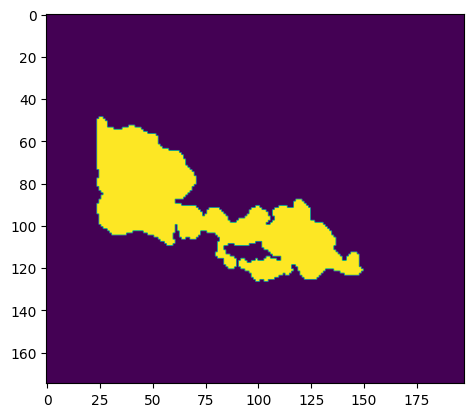

In [32]:
for ix in ['1796_1795', '1796_2026', '1796_2027', '1796_2194', '1796_2327',
       '1796_2372', '1796_2749', '1796_2760', '1796_3822', '1796_3839',
       '1796_3943', '1796_4620', '1796_4791', '1796_4895', '1796_4935',
       '1796_5088', '1796_5091', '1796_5342', '1796_5647', '1796_5711',
       '1796_5945', '1796_6188', '1796_6308', '1796_6432', '1796_6885',
       '1796_7020', '1796_7103', '1796_7211', '1796_7234', '1796_7256',
       '1796_7268', '1796_7361', '1796_7486', '1796_7534', '1796_7695',
       '1796_7847', '1796_7870', '1796_8013', '1796_8029', '1796_8044',
       '1796_8211', '1796_8276', '1796_8404', '1796_8579', '1796_8641',
       '1796_8853', '1796_8970', '1796_9783', '1796_9900', '1796_9964',
       '1796_10234', '1796_10359', '1796_10518', '1796_10562',
       '1796_10702', '1796_10726', '1796_11094', '1796_11292',
       '1796_11491', '1796_12176', '1796_12232', '1796_12291',
       '1796_12376', '1796_12615', '1796_12714', '1796_12801',
       '1796_13071', '1796_13205', '1796_13330', '1796_13378',
       '1796_13490', '1796_13610', '1796_13630', '1796_13857',
       '1796_14024', '1796_14049', '1796_14210', '1796_14715',
       '1796_14717', '1796_14805', '1796_15166', '1796_15200',
       '1796_15201', '1796_15267', '1796_15357', '1796_15411',
       '1796_15503', '1796_15560', '1796_15583', '1796_15800',
       '1796_15870', '1796_15963']:
        
    oS , cIm, cO = process_row3(inImg, oDF[oDF.ImageID_CellID==ix].iloc[0])
    print(oS)
# from skimage.morphology import convex_hull_image

# plt.imshow(cIm)
# plt.figure()
# plt.imshow(convex_hull_image(cIm))
# cO.plot_branching_structure()
# cO.plot_sholl_results()

In [22]:
 oDF[oDF.ImageID_CellID==ix].iloc[0]

Unnamed: 0                                8403
spatial_X                          2174.806265
spatial_Y                            73.156613
Area                                       862
Area (µm^2)                           159.3105
ImageID                                  Ctl-3
ImageType                                  Ctl
Parent                             Grey Matter
Distance to nearest Plaque (µm)        10.6071
ImageID_CellID                       1796_8404
numCellCentroids                           1.0
ImageIDOLD                                1796
CellID                                    8404
Name: 2296, dtype: object

In [23]:
inImg

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

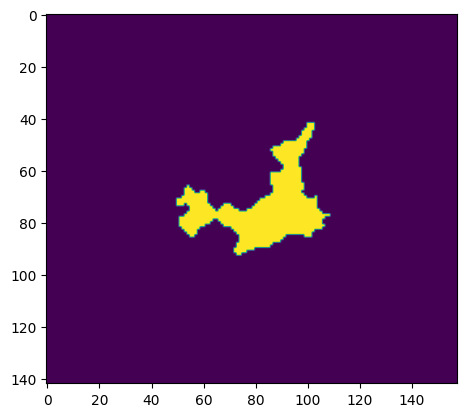

In [31]:
cell_image = binary_dilation(getCrop(inImg, keepID =8404))
plt.imshow(getCrop(inImg, keepID =8404))

In [ ]:
plt.imshow()

In [15]:
oS

surface_area                        494.00
total_length                          9.00
avg_process_thickness                54.90
convex_hull                         545.00
no_of_forks                           0.00
no_of_primary_branches                0.00
no_of_secondary_branches              0.00
no_of_tertiary_branches               0.00
no_of_quatenary_branches              0.00
no_of_terminal_branches               0.00
avg_length_of_primary_branches        0.00
avg_length_of_secondary_branches      0.00
avg_length_of_tertiary_branches       0.00
avg_length_of_quatenary_branches      0.00
avg_length_of_terminal_branches       0.00
critical_radius                       1.00
critical_value                        2.00
enclosing_radius                      5.00
ramification_index                     inf
skewness                              1.42
coefficient_of_determination          0.97
sholl_regression_coefficient          0.53
regression_intercept                 -0.65
dtype: floa

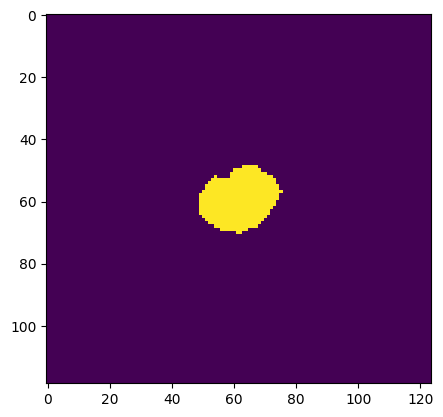

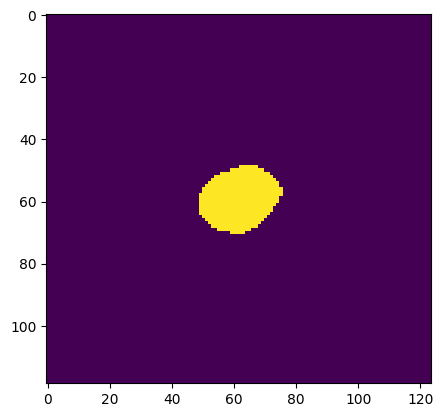

In [16]:
from skimage.morphology import convex_hull_image

plt.imshow(cIm)
plt.figure()
plt.imshow(convex_hull_image(cIm))

In [22]:
convex_hull_image(cIm)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [16]:
Cell()

TypeError: Cell.__init__() missing 2 required positional arguments: 'cell_image' and 'image_type'

In [17]:
cIm.sum(), convex_hull_image(cIm).sum()

(1362, 2522)

In [20]:
cOut = Cell(cIm, image_type='DAB', crop_tech='manual',sholl_step_size=SHOLL_STEP_SIZE,polynomial_degree=POLYNOMIAL_DEGREE)

In [21]:
cOut.features

{'surface_area': 1362,
 'total_length': 148.0,
 'avg_process_thickness': 9.2,
 'convex_hull': 2522,
 'no_of_forks': 4,
 'no_of_primary_branches': 2,
 'no_of_secondary_branches': 4,
 'no_of_tertiary_branches': 2,
 'no_of_quatenary_branches': 2,
 'no_of_terminal_branches': 7,
 'avg_length_of_primary_branches': 33.0,
 'avg_length_of_secondary_branches': 13.0,
 'avg_length_of_tertiary_branches': 5.0,
 'avg_length_of_quatenary_branches': 10.5,
 'avg_length_of_terminal_branches': 12.0,
 'critical_radius': 39,
 'critical_value': 3.5,
 'enclosing_radius': 54,
 'ramification_index': 1.75,
 'skewness': -0.1,
 'coefficient_of_determination': 0.83,
 'sholl_regression_coefficient': 1.03,
 'regression_intercept': -0.97}

In [13]:
import os
from tqdm.notebook import tqdm

for imID in tqdm(inDF.ImageIDOLD.unique(), total=8):
    if os.path.exists(f'../Bahareh/Mout/{imID}_MG_SkelFeat.csv'):
        print(f'../Bahareh/Mout/{imID}_MG_SkelFeat.csv exists. Skipping...')
        continue
    oDF, inImg = getInputs(inDF, imID)
    print(oDF.shape)
    results = []
    for ix, row in tqdm(oDF.iterrows(), total=oDF.shape[0]):
        results.append(process_row(inImg, row))
    oDF = pd.concat([oDF, pd.DataFrame(results, index=oDF.index)], axis=1)
    oDF.to_csv(f'../Bahareh/Mout/{imID}_MG_SkelFeat.csv', index=False)
#oDF = pd.concat([oDF] + results, axis=1)

# The ProgressBar will show the progress of the computations
#with ProgressBar():
#    oDF = oDF.compute()

# Display the updated DataFrame
print(oDF.head())

  0%|          | 0/8 [00:00<?, ?it/s]

../Bahareh/Mout/1796_MG_SkelFeat.csv exists. Skipping...
../Bahareh/Mout/3196_MG_SkelFeat.csv exists. Skipping...
../Bahareh/Mout/2997_MG_SkelFeat.csv exists. Skipping...
../Bahareh/Mout/1873_MG_SkelFeat.csv exists. Skipping...
../Bahareh/Mout/3026_MG_SkelFeat.csv exists. Skipping...
../Bahareh/Mout/3155_MG_SkelFeat.csv exists. Skipping...
../Bahareh/Mout/3280_MG_SkelFeat.csv exists. Skipping...
Reading image file: ../Bahareh/GMask/3628_labeledMG.tif


KeyboardInterrupt: 

In [10]:
pd.concat([oDF, pd.DataFrame(results)], axis=1)

NameError: name 'oDF' is not defined

![](https://www.frontiersin.org/files/Articles/701673/fncel-15-701673-HTML/image_m/fncel-15-701673-g003.jpg)

In [26]:
import dask
from dask.diagnostics import ProgressBar

# Helper function for processing each row
def process_row(inIm, row):
    flag = 1
    cell_image = binary_dilation(getCrop(inIm, keepID =row['CellID']))

    try:
        cell = Cell(cell_image, image_type='DAB', crop_tech='manual',
                    sholl_step_size=SHOLL_STEP_SIZE,
                    polynomial_degree=POLYNOMIAL_DEGREE)
    except:
        print(row.name, row, "ERRR")
        flag = 0
    if flag:
        return pd.Series(cell.features)
    else:
        return pd.Series({})

# Wrap the processing function with dask.delayed
#delayed_process_row = dask.delayed(process_row)

# Create a list of delayed computations for each row
#tasks = [delayed_process_row(inImg.asarray(), row) for _, row in oDF.iterrows()]

# Concatenate the results and set them back to the original DataFrame
print("here...")
#with ProgressBar():
#    results = dask.compute(*tasks)
#    oDF = pd.concat([oDF, pd.DataFrame(results)], axis=1)
results = []
from tqdm.notebook import tqdm
for ix, row in tqdm(oDF.iterrows(), total=oDF.shape[0]):
    results.append(process_row(inImg, row))
oDF = pd.concat([oDF, pd.DataFrame(results)], axis=1)
#oDF = pd.concat([oDF] + results, axis=1)

# The ProgressBar will show the progress of the computations
#with ProgressBar():
#    oDF = oDF.compute()

# Display the updated DataFrame
print(oDF.head())

here...


  0%|          | 0/5071 [00:00<?, ?it/s]

1 Unnamed: 0                                 1794
spatial_X                          13491.046358
spatial_Y                          11876.990066
Area                                        302
Area (µm^2)                             53.9108
ImageID                                   Ctl-3
ImageType                                   Ctl
Parent                              Grey Matter
Distance to nearest Plaque (µm)        308.6889
ImageID_CellID                        1796_1795
numCellCentroids                            1.0
ImageIDOLD                                 1796
CellID                                     1795
Name: 1, dtype: object ERRR
88 Unnamed: 0                                 2025
spatial_X                          14240.412088
spatial_Y                          10901.282967
Area                                        364
Area (µm^2)                             64.8057
ImageID                                   Ctl-3
ImageType                                   Ctl
Parent 

In [29]:
#
# oDF = pd.concat([oDF, pd.DataFrame(results)], axis=1)
oDF.to_csv('../Bahareh/Mout/1796_MG_SkelFeat.csv', index=False)

oDF.isna().sum()

Unnamed: 0                            0
spatial_X                             0
spatial_Y                             0
Area                                  0
Area (µm^2)                           0
ImageID                               0
ImageType                             0
Parent                                0
Distance to nearest Plaque (µm)       0
ImageID_CellID                        0
numCellCentroids                      0
ImageIDOLD                            0
CellID                                0
surface_area                         92
total_length                         92
avg_process_thickness                92
convex_hull                          92
no_of_forks                          92
no_of_primary_branches               92
no_of_secondary_branches             92
no_of_tertiary_branches              92
no_of_quatenary_branches             92
no_of_terminal_branches              92
avg_length_of_primary_branches       92
avg_length_of_secondary_branches     92


In [ ]:

def getCrop2(inM, x, y, w, h,keepID):
    return (inM[x:x+w,y:y+h]==keepID).astype(np.uint8)

def getCrop(inM, keepID):
    # Find the coordinates of all non-zero pixels with the specified keepID
    non_zero_coords = np.argwhere(inM == keepID)
    
    # Extract the minimum and maximum x and y coordinates
    x_min, y_min = np.min(non_zero_coords, axis=0)
    x_max, y_max = np.max(non_zero_coords, axis=0)
    
    # Calculate width (w) and height (h) based on the min and max coordinates
    # pad by 50
    pad = 50
    #w = x_max - x_min + pad
    #h = y_max - y_min + pad
    
    return (inM[x_min-pad:x_max+pad, y_min-pad:y_max+pad]==keepID).astype(np.uint8)

def skeletonCrop(inM):
    return skeletonize(inM)
iC = 336
iC2 = int(iC/2)
iX = 1795
plt.figure(figsize=(10, 10))

#cell_image = binary_dilation(getCrop(inImg.asarray(), oDF.Y_centroid.astype(int).values[iX]-iC2, oDF.X_centroid.astype(int).values[iX]-iC2, iC, iC,
#                   keepID =oDF['CellID'].astype(np.uint32).values[iX]))
#cell_image = binary_dilation(getCrop(inImg.asarray(), keepID =oDF['CellID'].astype(np.uint32).values[iX]))
cell_image = binary_dilation(getCrop(inImg, keepID =iX))

import cv2
import numpy as np
from skimage.feature import blob_log, blob_dog, blob_doh

dist_map = cv2.distanceTransform(cell_image.astype(np.uint8), cv2.DIST_L2, cv2.DIST_MASK_PRECISE)
_,radius, _, center = cv2.minMaxLoc(dist_map)


fig,ax=plt.subplots(1,1)
ax.imshow(cell_image,cmap='gray')
x, y = center
r = radius
c = plt.Circle((x, y), r, color="red", linewidth=2, fill=False)
ax.add_patch(c)
ax.set_axis_off()


In [7]:
from tqdm.notebook import tqdm
iC = 336
iC2 = int(iC/2)
for ix, row in tqdm(oDF.iterrows(), total=oDF.shape[0]):
    flag = 1
    cell_image = binary_dilation(getCrop(inImg.asarray(), row.Y_centroid.astype(int)-iC2, row.X_centroid.astype(int)-iC2, iC, iC,
                   keepID =row['CellID'].astype(np.uint32)))
    try:
        cell = Cell(cell_image, image_type='DAB', crop_tech='manual',
                    sholl_step_size=SHOLL_STEP_SIZE,
                    polynomial_degree=POLYNOMIAL_DEGREE)
    except:
        print(ix, row, "ERRR")
        flag = 0
    if flag:
        oDF.loc[ix,cell.features.keys()] = pd.Series(cell.features)
    
    

  0%|          | 0/5158 [00:00<?, ?it/s]

Extracting features...
Extracting features...
Extracting features...
Extracting features...
Extracting features...
Extracting features...
Extracting features...
Extracting features...
Extracting features...
Extracting features...
Extracting features...
Extracting features...
Extracting features...
Extracting features...
Extracting features...
Extracting features...
Extracting features...
Extracting features...
Extracting features...
Extracting features...
Extracting features...
Extracting features...
Extracting features...
Extracting features...
Extracting features...
Extracting features...
Extracting features...
Extracting features...
Extracting features...
Extracting features...
Extracting features...
Extracting features...
Extracting features...
Extracting features...
Extracting features...
Extracting features...
Extracting features...
Extracting features...
Extracting features...
Extracting features...
Extracting features...
Extracting features...
Extracting features...
Extracting 

In [14]:
#oDF.to_csv('../Bahareh/1796_MG_SkelFeat.csv', index=False)
oDF

,CellID,X_centroid,Y_centroid,#Branches,surface_area,total_length,avg_process_thickness,convex_hull,no_of_forks,no_of_primary_branches,...,avg_length_of_quatenary_branches,avg_length_of_terminal_branches,critical_radius,critical_value,enclosing_radius,ramification_index,skewness,coefficient_of_determination,sholl_regression_coefficient,regression_intercept
0,7559.0,2576.735559,1981.266561,21.0,10426.0,495.0,21.1,18962.0,10.0,3.0,...,30.0,30.8,24.0,6.59,177.0,2.20,0.75,0.89,1.64,1.54
1,7840.0,6216.746158,1332.299947,31.0,10339.0,587.0,17.6,13230.0,14.0,4.0,...,20.5,26.6,36.0,7.17,123.0,1.79,0.31,0.95,0.04,-2.22
2,2797.0,13185.214626,9457.869634,38.0,10254.0,637.0,16.1,17320.0,19.0,4.0,...,16.4,16.8,48.0,6.33,150.0,1.58,0.08,0.90,0.03,-2.62
3,5665.0,7986.221516,4990.196078,39.0,9641.0,635.0,15.2,18238.0,16.0,4.0,...,16.9,19.1,33.0,6.50,120.0,1.62,0.31,0.93,0.03,-2.42
4,5194.0,6667.726550,5611.022787,31.0,9441.0,462.0,20.4,7388.0,17.0,4.0,...,9.2,11.6,54.0,5.73,102.0,1.43,-0.02,0.78,0.03,-3.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5153,15244.0,2963.169051,19410.969793,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5154,15598.0,2982.511924,17939.056704,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5155,15420.0,1541.361950,18702.172761,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5156,15668.0,2393.428723,17639.904610,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
oDF

,CellID,X_centroid,Y_centroid,#Branches,surface_area,total_length,avg_process_thickness,convex_hull,no_of_forks,no_of_primary_branches,...,avg_length_of_quatenary_branches,avg_length_of_terminal_branches,critical_radius,critical_value,enclosing_radius,ramification_index,skewness,coefficient_of_determination,sholl_regression_coefficient,regression_intercept
0,7559.0,2576.735559,1981.266561,21.0,10426.0,495.0,21.1,18962.0,10.0,3.0,...,30.0,30.8,25.0,6.58,175.0,2.19,0.71,0.88,1.68,1.71
1,7840.0,6216.746158,1332.299947,31.0,10339.0,587.0,17.6,13230.0,14.0,4.0,...,20.5,26.6,35.0,7.11,120.0,1.78,0.43,0.94,0.04,-2.26
2,2797.0,13185.214626,9457.869634,38.0,10254.0,637.0,16.1,17320.0,19.0,4.0,...,16.4,16.8,50.0,6.09,150.0,1.52,-0.21,0.90,0.03,-2.64
3,5665.0,7986.221516,4990.196078,39.0,9641.0,635.0,15.2,18238.0,16.0,4.0,...,16.9,19.1,35.0,6.45,120.0,1.61,0.10,0.93,0.03,-2.47
4,5194.0,6667.726550,5611.022787,31.0,9441.0,462.0,20.4,7388.0,17.0,4.0,...,9.2,11.6,50.0,5.20,100.0,1.30,0.07,0.79,0.02,-3.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5153,15244.0,2963.169051,19410.969793,1.0,405.0,15.0,27.0,40.0,0.0,0.0,...,0.0,0.0,5.0,1.00,10.0,inf,NaN,1.00,1.00,-1.84
5154,15598.0,2982.511924,17939.056704,3.0,420.0,42.0,10.0,296.0,1.0,3.0,...,0.0,14.7,5.0,3.00,15.0,1.00,-0.71,0.96,0.22,-1.11
5155,15420.0,1541.361950,18702.172761,1.0,408.0,21.0,19.4,96.0,0.0,0.0,...,0.0,0.0,5.0,1.00,15.0,inf,NaN,1.00,1.00,-1.84
5156,15668.0,2393.428723,17639.904610,5.0,406.0,40.0,10.2,237.0,1.0,2.0,...,0.0,14.0,10.0,3.00,20.0,1.50,-0.20,0.99,0.17,-1.45


<Axes: xlabel='ramification_index', ylabel='critical_radius'>

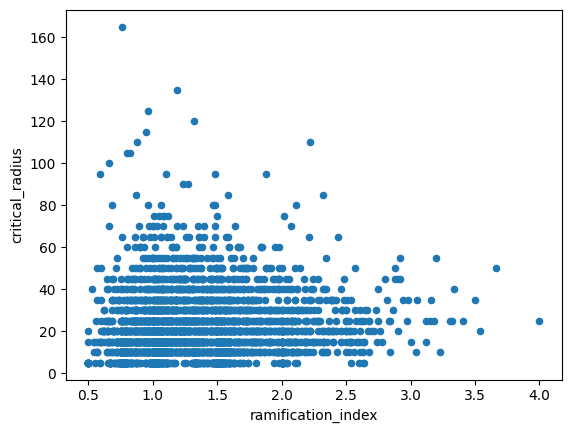

In [31]:
oDF[oDF.ramification_index<100].plot.scatter(x='ramification_index', y='critical_radius')

<Axes: ylabel='Frequency'>

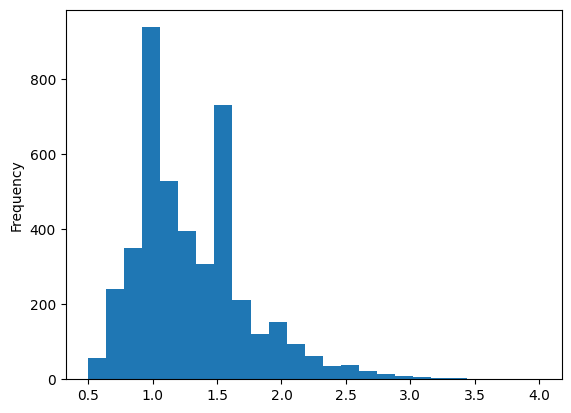

In [27]:
oDF[oDF.ramification_index<100].ramification_index.plot(kind='hist', bins=25)

In [28]:
oDF[oDF.ramification_index<0.8]

,CellID,X_centroid,Y_centroid,#Branches,surface_area,total_length,avg_process_thickness,convex_hull,no_of_forks,no_of_primary_branches,...,avg_length_of_quatenary_branches,avg_length_of_terminal_branches,critical_radius,critical_value,enclosing_radius,ramification_index,skewness,coefficient_of_determination,sholl_regression_coefficient,regression_intercept
6,6730.0,6160.307366,3334.658188,19.0,8737.0,426.0,20.5,10354.0,9.0,4.0,...,22.1,17.7,165.0,3.04,165.0,0.76,0.03,0.82,1.02,-1.17
37,4100.0,5457.074722,7301.006889,33.0,6539.0,513.0,12.7,10069.0,15.0,4.0,...,12.5,11.1,70.0,2.63,220.0,0.66,0.24,0.89,1.07,-0.83
38,7282.0,1701.377848,2511.658718,17.0,6324.0,397.0,15.9,11044.0,8.0,4.0,...,13.6,21.3,35.0,2.73,215.0,0.68,0.43,0.93,1.38,0.31
285,6436.0,1549.947006,3750.132485,10.0,3837.0,217.0,17.7,4064.0,5.0,4.0,...,9.5,12.4,15.0,2.56,100.0,0.64,0.00,0.91,1.29,-0.19
300,4343.0,15304.716481,6839.427663,5.0,3731.0,155.0,24.1,2306.0,3.0,4.0,...,0.0,19.6,20.0,3.09,65.0,0.77,1.33,0.92,1.23,-0.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5013,15358.0,3157.127716,18965.023847,5.0,1135.0,100.0,11.4,1387.0,2.0,4.0,...,0.0,14.0,5.0,3.12,60.0,0.78,0.88,0.87,1.33,-0.45
5015,15824.0,1489.878113,16911.499735,7.0,1140.0,112.0,10.2,1654.0,3.0,4.0,...,0.0,19.0,10.0,2.84,50.0,0.71,0.22,0.90,1.37,-0.03
5038,15368.0,3415.474298,18941.441441,3.0,979.0,61.0,16.0,428.0,1.0,2.0,...,0.0,21.0,30.0,1.56,40.0,0.78,2.27,0.88,0.91,-2.03
5072,15640.0,1946.687864,17785.638580,3.0,831.0,57.0,14.6,365.0,1.0,2.0,...,0.0,19.7,5.0,1.00,50.0,0.50,NaN,1.00,1.00,-1.84


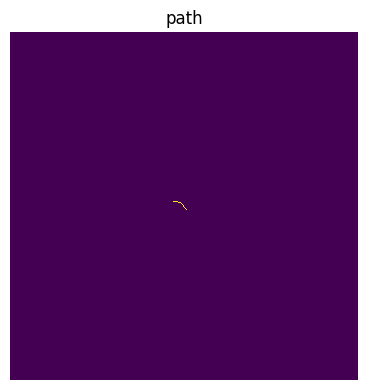

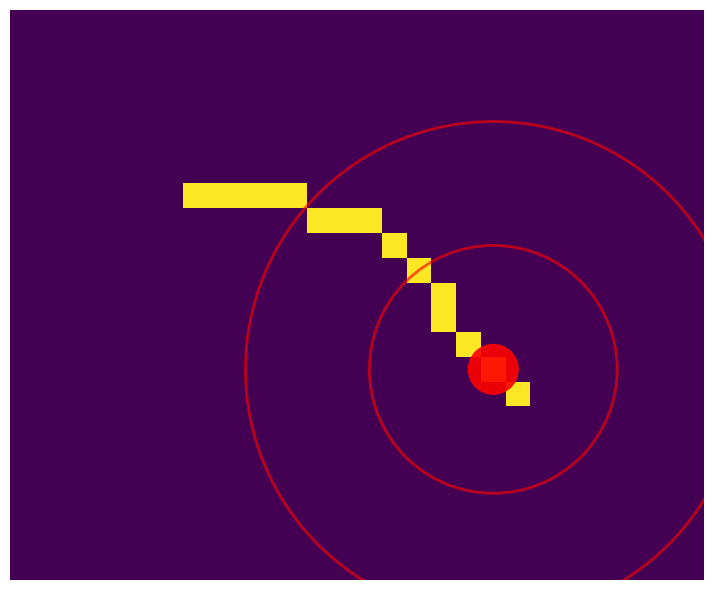

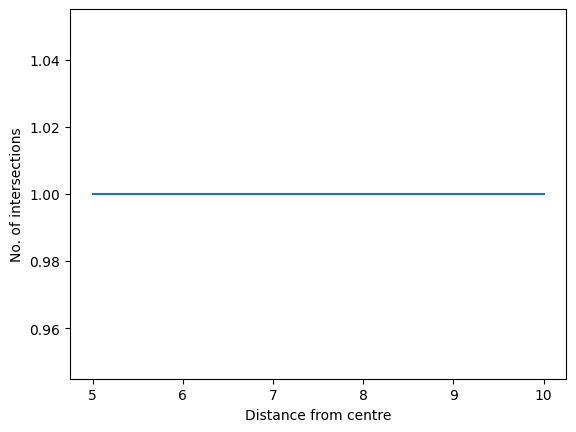

In [12]:
cell.plot_branching_structure()
cell.plot_sholl_results()

In [ ]:

# blobs = blob_dog(cell_image,threshold=0.0)
# fig,ax=plt.subplots(1,1)
# ax.imshow(cell_image,cmap='gray')
# for blob in blobs:
#     y, x, r = blob
#     c = plt.Circle((x, y), r, color="yellow", linewidth=2, fill=False)
#     ax.add_patch(c)
# ax.set_axis_off()

Extracting features...


In [32]:
cell.features

{'surface_area': 1135,
 'total_length': 100.0,
 'avg_process_thickness': 11.4,
 'convex_hull': 1387,
 'no_of_forks': 2,
 'no_of_primary_branches': 4,
 'no_of_secondary_branches': 0,
 'no_of_tertiary_branches': 0,
 'no_of_quatenary_branches': 0,
 'no_of_terminal_branches': 4,
 'avg_length_of_primary_branches': 14.0,
 'avg_length_of_secondary_branches': 0,
 'avg_length_of_tertiary_branches': 0,
 'avg_length_of_quatenary_branches': 0,
 'avg_length_of_terminal_branches': 14.0,
 'critical_radius': 5,
 'critical_value': 3.12,
 'enclosing_radius': 60,
 'ramification_index': 0.78,
 'skewness': 0.88,
 'coefficient_of_determination': 0.87,
 'sholl_regression_coefficient': 1.33,
 'regression_intercept': -0.45}

In [ ]:
# cell = sm.Cell(cell_image, image_type='DAB', crop_tech='manual',
#                #contrast_ptiles=contrast_ptiles,
#                #threshold_method=threshold_method,
#                sholl_step_size=SHOLL_STEP_SIZE,
#                polynomial_degree=POLYNOMIAL_DEGREE)
# plot(cell.cleaned_image)

In [ ]:
# View the extracted features
cell.features

{'surface_area': 5663.0,
 'total_length': 524.0,
 'avg_process_thickness': 10.8,
 'convex_hull': 10139,
 'no_of_forks': 14,
 'no_of_primary_branches': 4,
 'no_of_secondary_branches': 4,
 'no_of_tertiary_branches': 6,
 'no_of_quatenary_branches': 20,
 'no_of_terminal_branches': 19,
 'avg_length_of_primary_branches': 11.0,
 'avg_length_of_secondary_branches': 24.0,
 'avg_length_of_tertiary_branches': 15.2,
 'avg_length_of_quatenary_branches': 14.8,
 'avg_length_of_terminal_branches': 15.7,
 'critical_radius': 35,
 'critical_value': 6.86,
 'enclosing_radius': 100,
 'ramification_index': 1.72,
 'skewness': 0.14,
 'coefficient_of_determination': 0.96,
 'sholl_regression_coefficient': 0.04,
 'regression_intercept': -2.19}

In [ ]:
# @title Interactively view feature
import smorph as sm
ALL_FEATURE_NAMES = list(sm.ALL_FEATURE_NAMES)

def view_feature(feature):
  return cell.features[feature]

_ = widgets.interact(view_feature, feature=[*ALL_FEATURE_NAMES])

interactive(children=(Dropdown(description='feature', options=('surface_area', 'total_length', 'avg_process_th…

## Step 2.1: Skeleton Analysis
Skeletal morphological features:
* `cell.features['surface_area']`: Sum of highlighted pixels of cleaned image
* `cell.features['total_length']`: Sum of highlighted pixels of skeleton
* `cell.features['avg_process_thickness']`: Average width of all branches
* `cell.features['convex_hull']`: Sum of pixels included in the smallest convex polygon that surround whole cell
* `cell.features['no_of_forks']`: Count of all the forking (furcation) points
* `cell.features['no_of_primary_branches']`: Count of primary branches
* `cell.features['no_of_secondary_branches']`: Count of secondary branches
* `cell.features['no_of_tertiary_branches']`: Count of tertiary branches
* `cell.features['no_of_quatenary_branches']`: Count of quatenary branches
* `cell.features['no_of_terminal_branches']`: Count of terminal branches
* `cell.features['avg_length_of_primary_branches']`: Average length of primary branches
* `cell.features['avg_length_of_secondary_branches']`: Average length of secondary branches
* `cell.features['avg_length_of_tertiary_branches']`: Average length of tertiary branches
* `cell.features['avg_length_of_quatenary_branches']`: Average length of quatenary branches
* `cell.features['avg_length_of_terminal_branches']`: Average length of terminal branches
  

In [ ]:
# Sum of highlighted pixels is calculated to get the skeleton area estimate
cell.features['total_length']

524.0

In [ ]:
# Sum of highlighted pixels is calculated to get the area estimate of astrocyte
cell.features['avg_process_thickness']

10.8

10139

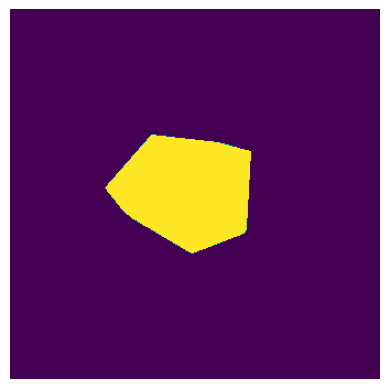

In [ ]:
# Sum of pixels included in the smallest convex polygon that surround all astrocyte pixels
cell.plot_convex_hull()
cell.features['convex_hull']

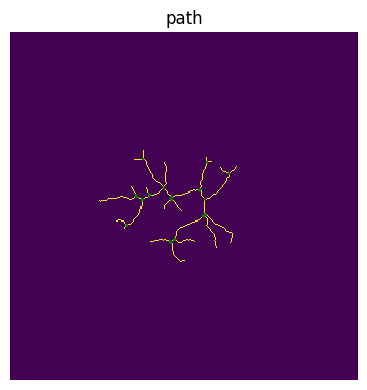

14

In [ ]:
# Count all the bifurcation points
cell.plot_forks()
cell.features['no_of_forks']

In [ ]:
for x in cell._branching_struct:
    for p in x:
        print(p)

[41, 46, 51, 56, 62, 61, 69, 75, 79]
[45, 50, 55, 60, 66, 67, 68, 73, 74, 79]
[154, 164, 172, 182, 193, 211, 223, 238, 256, 268]
[268, 280, 285, 289, 293, 297, 301, 305, 309, 313, 316, 319, 321, 323, 325]
[24, 31, 34, 37, 40, 44, 49, 54, 59, 65, 72, 78, 82, 86, 90, 94, 98, 102, 106, 111, 116, 120, 124, 128, 132, 137, 143, 154]
[154, 153, 152, 151, 163, 150, 149, 162, 161, 160, 171, 170, 181, 180, 179, 192, 191, 190, 210, 209, 208, 207, 206, 205, 204, 222, 221, 237]
[325, 327, 331]
[325, 328, 332, 336, 340, 344, 351, 362, 369, 375, 384, 385, 386, 392, 393, 398, 399, 405, 406, 410, 413, 416, 419, 420, 423, 424, 425, 428, 431, 434, 437, 440, 443, 457, 478, 489, 496]
[8, 10, 20, 22, 24]
[24, 25, 26, 27, 28]
[136, 142, 148, 159, 169, 178, 189, 203, 220, 237]
[237, 255, 266]
[331, 330, 334, 338, 342, 349, 360, 359, 358, 367, 366, 365, 373, 372, 382, 381, 380, 390, 389, 396, 395, 403, 402, 401, 408, 411, 414, 417, 421, 426, 429, 432, 435, 438, 441, 451]
[331, 335, 339, 343, 350, 361, 368, 374

In [ ]:
import numpy as np
np.max(cell._branch_coords)

221

In [ ]:
def plot_branching_structure(cell, colors=['r', 'b', 'm', 'g', 'c']):
    """Plots skeleton of the cell with all levels of branching highlighted.

    Parameters
    ----------
    colors : list, optional
        List of colors that distinctively highlight all levels of branching
        -- primary, secondary, tertiary, quaternary, & terminal,
        respectively, by default ['r','b','m','g','c']

    """
    #color_validations = list(map(is_color_like, colors))
    #if sum(color_validations) != len(color_validations):
    #    print(f'{colors} is not a valid list of colors. '
    #            'Resetting colors to ["r","b","m","g","c"].')
    colors = ['r', 'b', 'm', 'g', 'c','k']

    branching_structure = cell._branching_struct
    coords = cell._branch_coords
    # store same level branch nodes in single array
    color_branches_coords = []
    for branch_level in branching_structure:
        single_branch_level = []
        for path in branch_level:
            path_coords = []
            for node in path:
                path_coords.append([coords[0][node],coords[1][node]])
            single_branch_level.extend(path_coords)

        color_branches_coords.append(single_branch_level)
    #print(single_branch_level)
    ax = plt.subplots(figsize=(4, 4))[1]
    ax.set_title('path')
    ax.imshow(cell.skeleton, interpolation='nearest')
    for j, color_branch in enumerate(color_branches_coords):
        if j > 4:
            j = 4
        for k in color_branch:
            #print(k)
            c = plt.Circle((k[1], k[0]), 0.5, color=colors[j])
            ax.add_patch(c)

    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

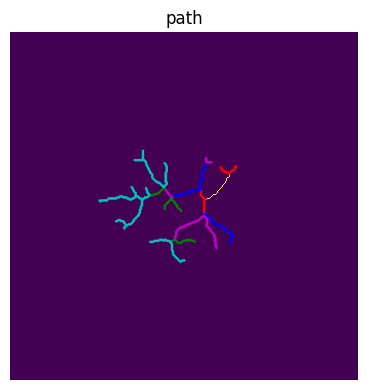

In [ ]:
# The branches are differentiated into primary, secondary and further levels to compare any branch level differences between astrocytes
cell.plot_branching_structure()

## Step 2.2: Sholl Analysis

Sholl analysis morphological features:

* `cell.features['critical_radius']`: Distance at which Critical value occurs (distance at which the Highest count of intersections occurred)
* `cell.features['critical_value']`: Local maximum of the polynomial fit (Maximum no. of intersections)
* `cell.features['enclosing_radius']`: The last (thus, the widest) of intersecting radii to be associated with the number of intersections
* `cell.features['ramification_index']`: Ratio between critical value and number of primary branches
* `cell.features['skewness']`: Indication of how symmetrical the distribution is around its mean
* `cell.features['coefficient_of_determination']`: How close the data are to the fitted regression (indicative of the level of explained variability in the data)
* `cell.features['sholl_regression_coefficient']`: Rate of decay of no. of branches
* `cell.features['regression_intercept']`: Y-intercept of the logarithmic Sholl plot

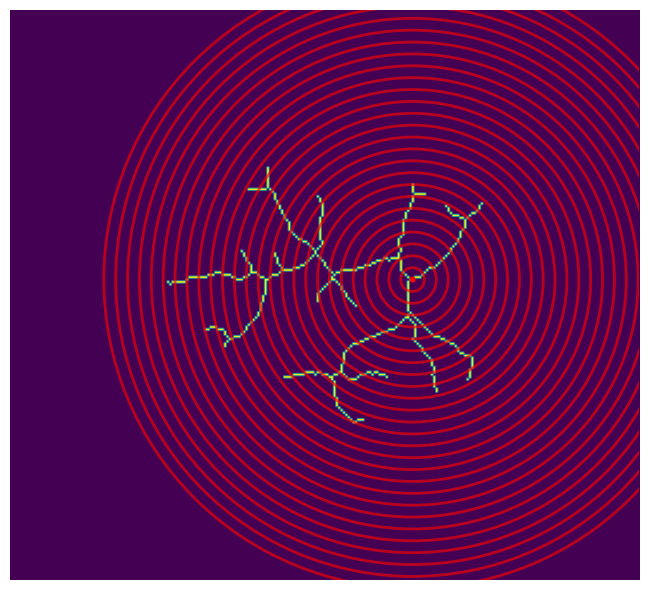

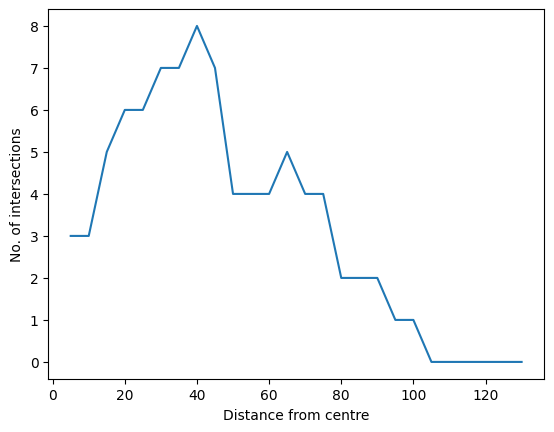

In [ ]:
# Number of intersections of astrocytic branches at regular distances from the soma
cell.plot_sholl_results()

Polynomial regression is used to mitigate the influence of local variations in the sampled data, and thereby better describe the relationship between intersections vs. distance

In [ ]:
cell.plot_polynomial_fit()

In [ ]:
# Distance at which Critical value occurs (distance at which the Highest count of intersections occurred)
cell.features['critical_radius']

72

In [ ]:
# Local maximum of the polynomial fit (Maximum no. of intersections)
cell.features['critical_value']

5.39

In [ ]:
# The last (thus, the widest) of intersecting radii to be associated with the number of intersections
cell.features['enclosing_radius']

123

In [ ]:
# Indication of how symmetrical the distribution is around its mean
cell.features['skewness']

0.35

In [ ]:
# Ratio between critical value and number of primary branches
cell.features['ramification_index']

inf

In [ ]:
# how close the data are to the fitted regression (indicative of the level of explained variability in the data set)
cell.features['coefficient_of_determination']

0.78

In [ ]:
# Rate of decay of no. of branches
cell.features['sholl_regression_coefficient']

0.02

In [ ]:
# Y intercept of the logarithmic plot
cell.features['regression_intercept']

-3.16